#SGDRegressor - Linear Regression with iterative optimization.
SGD offers a lot of control over optimization procedure through a number of hyperparameters. However we need to set them to right values in order to make it work for training the model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(306)

In [ ]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

* Load the data and split it into traininng and test dataset

In [ ]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

Divide data into train and dev datasets

In [ ]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

#Baseline SGDRegressor
* Step1: To begin with, we instantiate a baseline SGDRegressor model with default parameters
* Step2: Train the model with training feature matrix and labels
* Step3: Obtain score on the training and Dev data

In [ ]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))

print('Mean Absolute Error on training set: ', train_mae)
print('Mean Absolute Error on development set: ', dev_mae)

Mean Absolute Error on training set:  312995824045833.75
Mean Absolute Error on development set:  315394681503071.94


The Mean Absolute Error is too high. The baseline model does not train well. This may happen due to large learning rate. 

Let us investigate thos issue by training the model step by step and recording training loss in each step.

#Adding a Feature Scaling Step
SGD is sensitive to feature scaling. 

In [ ]:
sgd_pipe = Pipeline(steps=[('feature_scaling', StandardScaler()),
                           ('sgd', SGDRegressor())
                           ])
sgd_pipe.fit(train_features,train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipe.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipe.predict(dev_features))

print('Mean Absolute Error on training set: ', train_mae)
print('Mean Absolute Error on development set: ', dev_mae)

Mean Absolute Error on training set:  0.5135804404077051
Mean Absolute Error on development set:  0.6373131245753217


The error is still high. Let us run SGDRegressor step by step and investigate the issues with training.

#Stepwise training of SGDRegressor
* Step1: Instantiate SGDRegressor with warm_start=True and tol=-np.infty.
* Step2: Train SGD step by step and record the regression loss in each step.
* Step3: Plot learning curve and see if there are any issues in training.

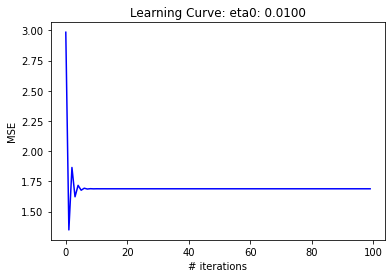

In [ ]:
eta0 = 1e-2
sgd_pipe = Pipeline(steps=[('feature_scaling', StandardScaler()),
                           ('sgd', SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, random_state=42))
                           ])
loss = []
for epoch in range(100):
  sgd_pipe.fit(train_features, train_labels)
  loss.append(mean_squared_error(train_labels, sgd_pipe.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('# iterations')
plt.ylabel('MSE')
plt.title(f'Learning Curve: eta0: {eta0:0.4f}')
plt.show()

The loss is reduces initially and then increased. This may be due to large learning rates. We will reduce the learning rate by a factor of 10 and retry the training.

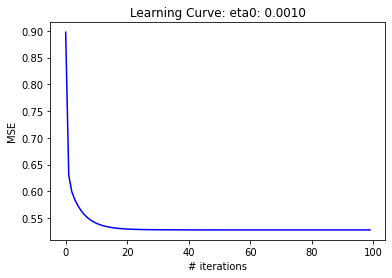

In [ ]:
eta0 = 1e-3
sgd_pipe = Pipeline(steps=[('feature_scaling', StandardScaler()),
                           ('sgd', SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, eta0=eta0, random_state=42))
                           ])
loss = []
for epoch in range(100):
  sgd_pipe.fit(train_features, train_labels)
  loss.append(mean_squared_error(train_labels, sgd_pipe.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('# iterations')
plt.ylabel('MSE')
plt.title(f'Learning Curve: eta0: {eta0:0.4f}')
plt.show()

This is an ideal learning curve, where the train loss reduces monotonically as the training progresses.

In [ ]:
print('# iteration before reaching convergence criteria: ', sgd_pipe[-1].n_iter_)
print('wieght updates: ', sgd_pipe[-1].t_)

# iteration before reaching convergence criteria:  1
wieght updates:  11611.0


In [ ]:
train_mae = mean_absolute_error(train_labels, sgd_pipe.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipe.predict(dev_features))

print('Mean Absolute Error on training set: ', train_mae)
print('Mean Absolute Error on development set: ', dev_mae)

Mean Absolute Error on training set:  0.5333732983042573
Mean Absolute Error on development set:  0.5190150280908042


#Fixing learning rate through validation curves
* Step1: Provide the list of values to be tried for a hyperparameter.
* Step2: Instatiate an object of validation_curve with estimator, training featues and labels. Set scoring parameter to relevent score.
* Step3: Convert score to error.
* Step4: Plot validation curve with value of hyperparameter on x-axis and error on y-axis.
* Step5: Fix the hyperparameter value where the test error is the least.

In [ ]:
%%time
eta0 = [1e-5, 1e-4, 1e-3, 1e-2]
# print(sgd_pipe.get_params().keys())
train_score, test_score = validation_curve(sgd_pipe, com_train_features, com_train_labels, 
                                           param_name='sgd__eta0', param_range=eta0,
                                           cv=shuffle_split_cv, scoring='neg_mean_squared_error', n_jobs=2)
train_errors, test_errors = -train_score, -test_score



CPU times: user 175 ms, sys: 15.7 ms, total: 190 ms
Wall time: 433 ms


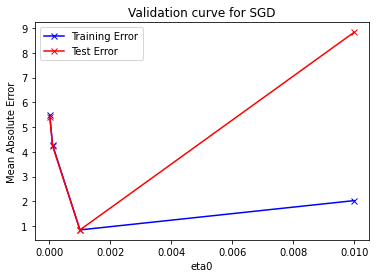

In [ ]:
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label='Training Error')
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label='Test Error')
plt.legend()
plt.xlabel('eta0')
plt.ylabel('Mean Absolute Error')
plt.title('Validation curve for SGD')
plt.show()

for eta0 = 1e-3, the test error is the least and hence we select that value as the value for eta0.

Next we plot standard deviation in errors.

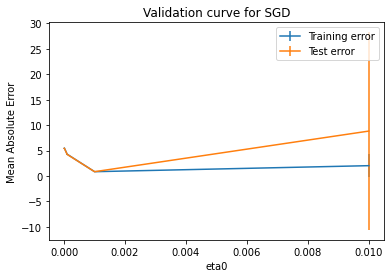

In [ ]:
plt.errorbar(eta0, train_errors.mean(axis=1), yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(eta0, test_errors.mean(axis=1), yerr=test_errors.std(axis=1), label='Test error')
plt.legend()
plt.xlabel('eta0')
plt.ylabel('Mean Absolute Error')
plt.title('Validation curve for SGD')
plt.show()

#SGDRegressor

In [ ]:
sgd_pipe = Pipeline(steps=[('feature_scaling', StandardScaler()),
                           ('sgd', SGDRegressor(max_iter=500,
                                                early_stopping=True,
                                                eta0=1e-3,
                                                tol=1e-3, 
                                                validation_fraction=0.2,
                                                n_iter_no_change=5,
                                                average=10,
                                                random_state=42))
                           ])
sgd_pipe.fit(train_features,train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipe.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipe.predict(dev_features))

print('Mean Absolute Error on training set: ', train_mae)
print('Mean Absolute Error on development set: ', dev_mae)

Mean Absolute Error on training set:  0.579376454514559
Mean Absolute Error on development set:  0.5689180241137523


In [ ]:
print('Number of SGD Iterations:', sgd_pipe[-1].n_iter_)
print('Number of weight updates:', sgd_pipe[-1].t_)

Number of SGD Iterations: 7
Number of weight updates: 81271.0


In [ ]:
sgd_pipe = Pipeline(steps=[('feature_scaling', StandardScaler()),
                           ('sgd', SGDRegressor(max_iter=500,
                                                early_stopping=True,
                                                eta0=1e-3,
                                                tol=1e-3, 
                                                learning_rate='constant',
                                                validation_fraction=0.2,
                                                n_iter_no_change=5,
                                                average=10,
                                                random_state=42))
                           ])
sgd_pipe.fit(train_features,train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipe.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipe.predict(dev_features))

print('Mean Absolute Error on training set: ', train_mae)
print('Mean Absolute Error on development set: ', dev_mae)
print('Number of SGD Iterations:', sgd_pipe[-1].n_iter_)
print('Number of weight updates:', sgd_pipe[-1].t_)

Mean Absolute Error on training set:  0.5359339681114987
Mean Absolute Error on development set:  0.5151099728924144
Number of SGD Iterations: 8
Number of weight updates: 92881.0


In [ ]:
sgd_pipe = Pipeline(steps=[('feature_scaling', StandardScaler()),
                           ('sgd', SGDRegressor(max_iter=500,
                                                early_stopping=True,
                                                eta0=1e-3,
                                                tol=1e-3, 
                                                learning_rate='adaptive',
                                                validation_fraction=0.2,
                                                n_iter_no_change=5,
                                                average=10,
                                                random_state=42))
                           ])
sgd_pipe.fit(train_features,train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipe.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipe.predict(dev_features))

print('Mean Absolute Error on training set: ', train_mae)
print('Mean Absolute Error on development set: ', dev_mae)
print('Number of SGD Iterations:', sgd_pipe[-1].n_iter_)
print('Number of weight updates:', sgd_pipe[-1].t_)

Mean Absolute Error on training set:  0.5340193046836148
Mean Absolute Error on development set:  0.5198356196858102
Number of SGD Iterations: 33
Number of weight updates: 383131.0


##Setting max_iter

In [ ]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
print(max_iter)

65.0


In [ ]:
sgd_pipe = Pipeline(steps=[('feature_scaling', StandardScaler()),
                           ('sgd', SGDRegressor(max_iter=max_iter,
                                                early_stopping=True,
                                                eta0=1e-3,
                                                tol=1e-3, 
                                                learning_rate='constant',
                                                validation_fraction=0.2,
                                                n_iter_no_change=5,
                                                average=10,
                                                random_state=42))
                           ])
sgd_pipe.fit(train_features,train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipe.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipe.predict(dev_features))

print('Mean Absolute Error on training set: ', train_mae)
print('Mean Absolute Error on development set: ', dev_mae)
print('Number of SGD Iterations:', sgd_pipe[-1].n_iter_)
print('Number of weight updates:', sgd_pipe[-1].t_)

Mean Absolute Error on training set:  0.5359339681114987
Mean Absolute Error on development set:  0.5151099728924144
Number of SGD Iterations: 8
Number of weight updates: 92881.0
